In [1]:
import numpy as np 
import pandas as pd 
import os
import zipfile

#Unzip the train and test files in the current directory
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall()

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from ucimlrepo import fetch_ucirepo
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
warnings.filterwarnings('ignore')
#pd.options.display.max_rows = None

In [5]:
train_df = pd.read_csv("train.csv", header=0)
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [7]:
test_df = pd.read_csv("test.csv", header=0)
test_df.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


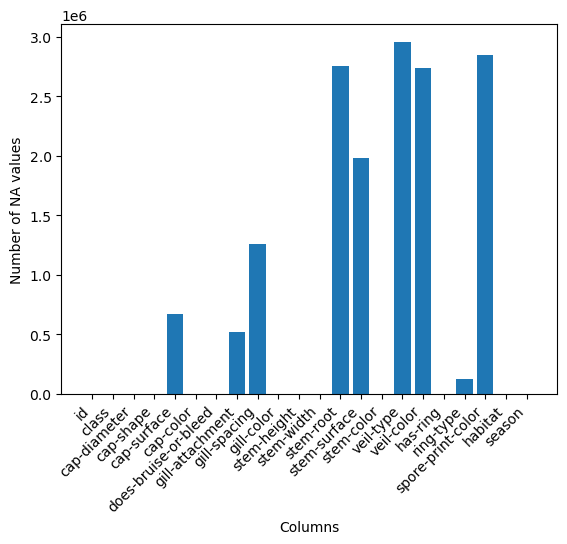

In [8]:
#Check the missing values across the table
plt.bar(train_df.isna().sum().index, train_df.isna().sum().values)
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of NA values')
plt.show()

In [9]:
train_df.isna().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

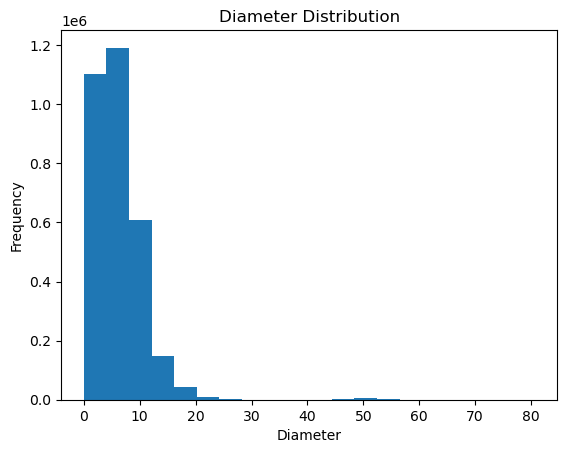

In [10]:
#Check the 'cap-diameter' distribution
plt.hist(train_df['cap-diameter'].dropna(), bins=20)
plt.title('Diameter Distribution')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.show()

In [11]:
#Distribution skewed so we'll use the median to fill the NA values
train_df['cap-diameter'] = train_df['cap-diameter'].fillna(train_df['cap-diameter'].median())

In [ ]:
#Loop through all object columns
for col in train_df.select_dtypes(include=['object']).columns:
    #Step 1: remove any words followed by a space and keep only the letter
    train_df[col] = train_df[col].replace(r'^\w+\s([a-z])$', r'\1', regex=True)

    #Step 2: replace any value that is not a single letter with NaN
    train_df[col] = train_df[col].where(train_df[col].str.match(r'^[a-z]$'), np.nan)

In [ ]:
#Adding 'stem-volume' to the dataframe because volume = (width/2)*height
train_df['stem-volume'] = train_df['stem-height']*(train_df['stem-width']/2)

In [ ]:
train_df.isna().sum()

In [ ]:
#Boxplot to check the potential correlation between a numeric feature & a categorical feature
sns.boxplot(x='season', y='cap-diameter', data=train_df)
plt.title('Boxplot of Diameter by Color')
plt.show()

In [ ]:
#Contingency table to check the potential correlation between two categorical features
contingency_table = pd.crosstab(train_df['habitat'], train_df['season'])
contingency_table.plot(kind='bar', stacked=True)
print(contingency_table)
#Use a graph to visualize the potential correlation
plt.title('Stacked Bar Plot of Feature1 vs Feature2')
plt.xlabel('Feature1')
plt.ylabel('Count')
plt.show()

In [ ]:
#Use the mode to fill NA values for 'cap-shape'
fill_NA = train_df['cap-shape'].mode()[0]
train_df['cap-shape'] = train_df['cap-shape'].fillna(fill_NA)

#Use the mode to fill values for 'cap-color'
fill_NA = train_df['cap-color'].mode()[0]
train_df['cap-color'] = train_df['cap-color'].fillna(fill_NA)

#This question can be answered by true or false only so we're gonna keep 't' or 'f', rest is gonna become NAs
#train_df['does-bruise-or-bleed'] = train_df['does-bruise-or-bleed'].replace(r'[^ft]', np.nan, regex=True)
#NOT USEFUL

In [ ]:
#Introducting the inspiration dataset for this playground series to get more training data
mushroom = fetch_ucirepo(id=73)
mush_X = mushroom.data.features
mush_Y = mushroom.data.targets
mush_X.info()

In [ ]:
#Adapt the new data to the current data
mush_X.columns = mush_X.columns.str.replace('stalk', 'stem', regex=False)

mush_X = mush_X.rename(columns={'bruises': 'does-bruise-or-bleed'})

mapping_ring = {'n': 'f', 'o': 't', 't': 't'}
mush_X['has-ring'] = mush_X['ring-number'].map(mapping_ring)
mush_X = mush_X.drop('ring-number', axis=1)

mush_X['class'] = mush_Y

mush_X['id'] = range(3116945, 3116945+len(mush_X))

mush_X = mush_X.drop(['odor', 'stem-shape', 'gill-size', 'stem-surface-above-ring', 'stem-surface-below-ring', 'stem-color-above-ring', 
                      'stem-color-below-ring', 'population'], axis=1)

In [ ]:
#Concatenate the two data sets to get a bigger training data set
big_train_df = pd.concat([train_df, mush_X], ignore_index=True)

In [ ]:
big_train_df.info()

In [ ]:
big_train_df.isna().sum()

In [ ]:
#Use an encoder to encode the training data and adapt them to the xgboost algorithm
label_encoder = LabelEncoder()

big_train_df = big_train_df.drop('id', axis=1)

for column in big_train_df.select_dtypes(include=['object']).columns:
    big_train_df[column] = label_encoder.fit_transform(big_train_df[column])

X = big_train_df.drop('class', axis=1)
y = big_train_df['class']

dtrain = xgb.DMatrix(X, label=y)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=100, metrics="auc", as_pandas=True, seed=42)

print(cv_results)
print(f"Mean AUC: {cv_results['test-auc-mean'].iloc[-1]}")

In [ ]:
#Get the best parameters for the model
best_num_boost_rounds = cv_results['test-auc-mean'].idxmax()

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_rounds
)

In [ ]:
#Adapt the test set to fit the xgboost expected formatting
test_df['cap-diameter'] = test_df['cap-diameter'].fillna(test_df['cap-diameter'].median())

for col in test_df.select_dtypes(include=['object']).columns:
    #step 1: remove any words followed by a space and keep only the letter
    test_df[col] = test_df[col].replace(r'^\w+\s([a-z])$', r'\1', regex=True)

    #step 2: replace any value that is not a single letter with NaN
    test_df[col] = test_df[col].where(test_df[col].str.match(r'^[a-z]$'), np.nan)

test_df['stem-volume'] = test_df['stem-height']*(test_df['stem-width']/2)

fill_NA = test_df['cap-shape'].mode()[0]
test_df['cap-shape'] = test_df['cap-shape'].fillna(fill_NA)

#use the mode to fill values
fill_NA = test_df['cap-color'].mode()[0]
test_df['cap-color'] = test_df['cap-color'].fillna(fill_NA)

for column in test_df.select_dtypes(include=['object']).columns:
    test_df[column] = label_encoder.fit_transform(test_df[column])

In [ ]:
test_df.info()

In [ ]:
for column in test_df.select_dtypes(include=['object']).columns:
    test_df[column] = label_encoder.fit_transform(test_df[column])

In [ ]:
#Make the final prediction
test = test_df.drop('id', axis=1)

data_dmatrix_test = xgb.DMatrix(data=test)

predictions = model.predict(data_dmatrix_test)

predictions = [0 if pred >= 0.5 else 1 for pred in predictions]

predictions = ['e' if pred == 1 else 'p' for pred in predictions]

submission_df = pd.DataFrame({'id' : test_df['id'], 'class' : predictions})
submission_df.to_csv('submission.csv', index=False)